In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [0]:
def inttostr(x):
  x = str(x)
  return x[:4]+'-'+x[4:6]+'-'+x[6:]

In [0]:
launch = pd.read_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/AppLaunched.csv')
launch['Date'] = pd.to_datetime(launch['Date'].apply(lambda x:inttostr(x)))
userids = launch.UserId.unique()

In [0]:
launch_cnt_dict = launch.groupby(['UserId']).size().to_dict()

launch_days_dict = {user:0 for user in userids}
first_entry = launch.groupby(['UserId']).first().to_dict('index')
last_entry = launch.groupby(['UserId']).last().to_dict('index')

for user in tqdm(userids):  
  launch_days_dict[user] = (last_entry[user]['Date'] - first_entry[user]['Date']).days;
  
  

100%|██████████| 449387/449387 [00:08<00:00, 54712.14it/s]


In [0]:
registration = pd.read_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/Registration.csv')
registration.Status=registration.Status.replace({'Complete':'Completed'})

last_entry = registration.groupby(['UserId']).last()
status_dict = last_entry.loc[:,'Status'].to_dict()
country_dict = last_entry.loc[:,'Country'].to_dict()

In [0]:
vidstarted = pd.read_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/VideoStarted.csv')
vidstarted = vidstarted[~vidstarted.UserId.isin(list(set(vidstarted.UserId.unique())-set(userids)))]

In [0]:
vid_watch_cnt_dict = vidstarted.groupby(['UserId']).size().to_dict()

In [0]:
genre_list = vidstarted.Genre.unique()
category_list = vidstarted.Category.unique()
program_list = vidstarted.ProgramType.unique()
#user_list = vidstarted.UserId.unique()

genre_dict={genre:0 for genre in genre_list}
category_dict = {cat:0 for cat in category_list}
program_dict = {program:0 for program in program_list}

user_dict = {user:{**genre_dict,**category_dict,**program_dict} for user in userids}#user_list }  
    

In [0]:
data_dict = vidstarted.to_dict('index');

In [0]:
for cnt,idx in enumerate(tqdm(data_dict)):
 
  user_dict[data_dict[idx]['UserId']][data_dict[idx]['Genre']]+=1
  user_dict[data_dict[idx]['UserId']][data_dict[idx]['Category']]+=1
  user_dict[data_dict[idx]['UserId']][data_dict[idx]['ProgramType']]+=1
  

100%|██████████| 1796516/1796516 [00:04<00:00, 367502.09it/s]


In [0]:
df = pd.DataFrame.from_dict(data=user_dict,orient='index')

In [0]:
launch_days_ser = pd.Series(launch_days_dict)
status_ser = pd.Series(status_dict)
country_ser = pd.Series(country_dict)
vid_watch_cnt_ser = pd.Series(vid_watch_cnt_dict)

df['launch_days'] = launch_days_ser
df['status'] = status_ser
df['country'] = country_ser
df['vid_watch_cnt'] = vid_watch_cnt_ser

In [0]:
df.status = df.status.replace({np.nan:'Unknown'});
df.country = df.country.replace({np.nan:'Unknown'});
df.vid_watch_cnt = df.vid_watch_cnt.replace({np.nan:0});

In [0]:
final_df = df.copy()
df = pd.get_dummies(df)

Text(0.5, 1.0, 'segmentation by KMeans')

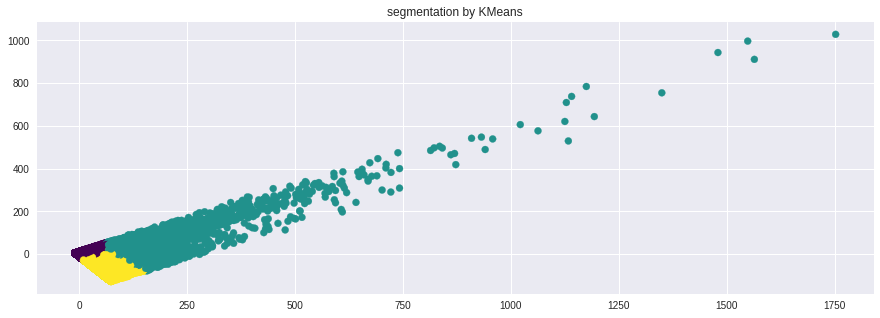

In [0]:
from sklearn.cluster import KMeans, MiniBatchKMeans
import seaborn as sns
km = KMeans(n_clusters=3,random_state=42)
#km = MiniBatchKMeans(n_clusters=4)
km.fit(df)
labels = km.predict(df)

from sklearn.decomposition import PCA
pca = PCA(n_components=2,random_state=42)
res = pca.fit_transform(df)

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,5))
plt.scatter(res[:,0],res[:,1],c=labels,cmap='viridis')
sns.despine(bottom=True, left=True)
plt.title('segmentation by KMeans')

In [0]:
edf = pd.DataFrame()
edf['predicted'] = labels
edf.index = userids
edf['predicted'].value_counts()


0    404379
2     38798
1      6210
Name: predicted, dtype: int64

In [0]:
uninstall_unique = pd.read_csv('drive/My Drive/Capstone/CleverTap Capstone/Data/uninstall_unique.csv')
uninstall_users = uninstall_unique.UserId.unique()
#actual = [1 if user not in uninstall_users else 0 for user in tqdm(userids)]
#edf['actual'] = actual

temp = [1]*len(uninstall_users)
edf['actual'] = pd.Series(temp,index=uninstall_users)
edf['actual'] = edf['actual'].replace({np.nan:0})

edf['predicted'] = labels
edf['predicted'] = edf['predicted'].replace({2:1})

In [0]:
from sklearn.metrics import f1_score,accuracy_score,precision_score,confusion_matrix,recall_score

f_score = f1_score(edf['actual'],edf['predicted'])
acc_score = accuracy_score(edf['actual'],edf['predicted'])

prec_score = precision_score(edf['actual'],edf['predicted'])
rec_score = recall_score(edf['actual'],edf['predicted'])

print('f1_score:'+str(f_score))
print('recall_score:'+str(rec_score))
print('precision_score:'+str(prec_score))
print('accuracy_score:'+str(acc_score))
print('confusion_matrix:')

confusion_matrix(edf['actual'],edf['predicted'],labels=[0,1])

f1_score:0.14197767863053234
recall_score:0.1011144845273341
precision_score:0.23826875222182722
accuracy_score:0.7115670902807603
confusion_matrix:


array([[309045,  34284],
       [ 95334,  10724]])

In [0]:
temp = [1]*449387
f_score = f1_score(edf['actual'],temp)
acc_score = accuracy_score(edf['actual'],temp)
prec_score = precision_score(edf['actual'],temp)
rec_score = recall_score(edf['actual'],temp)

print('f1_score:'+str(f_score))
print('precision_score:'+str(prec_score))
print('recall_score:'+str(rec_score))
print('accuracy_score:'+str(acc_score))
print('confusion_matrix:')

confusion_matrix(edf['actual'],temp,labels=[0,1])

f1_score:0.3818847950742198
precision_score:0.23600593697637004
recall_score:1.0
accuracy_score:0.23600593697637004
confusion_matrix:


array([[     0, 343329],
       [     0, 106058]])

In [0]:
edf.actual.value_counts()

0.0    343329
1.0    106058
Name: actual, dtype: int64